# CEE6501 — Lecture 4.2

## Implementing the DSM for Planar Trusses in Python

## Learning Objectives

By the end of this lecture, you will be able to:

- Translate a planar truss problem into **structured Python inputs**
  (nodes, elements, material properties, loads, and supports)
- Implement the **Direct Stiffness Method workflow** step by step in code

## Agenda

1. Intro to the Problem
2. Code Implemetation
   1. Defining inputs: nodes, elements, DOFs, supports, and loads
   2. Computing element geometry and stiffness matrices
   3. Assembling the global stiffness matrix and force vector
   4. Applying boundary conditions by DOF partitioning
   5. Solving for unknown displacements and reaction forces
   6. Backward pass: recovering element forces and stresses
   7. Post-processing and output
3.  In-class assignment

## Writing Code for Structural Analysis

The goal is **clarity first**, performance second.

In this lecture we intentionally:
- mirror hand calculations in code, and
- use readable, explicit steps rather than compact “clever” implementations.

Optimization comes later—after correctness and understanding.

### Structure of Your Code

A well-structured DSM implementation separates **problem definition** from **analysis logic**.

This separation matters because:
- only the *inputs* change from problem to problem,
- the solver logic should be reusable and trustworthy.

1. **Inputs and setup**  
   Geometry, connectivity, material properties (problem-specific)

2. **Parsing / pre-processing**  
   Convert user inputs into solver-ready arrays

3. **Analysis / computation**  
   Element stiffness → global assembly → solution

4. **Outputs / post-processing**  
   Displacements, reactions, internal forces

Only **Step 1** should change between different truss problems.


## Problem

Example 3.9 in Kassimali

<div style="display:flex; gap:1.5rem; align-items:center;">
  <div style="flex:0.80;">
    <img src="assets/L2_Problem.png" style="width:100%; margin-bottom:0.75rem;">
  </div>
</div>

## Units Used in This Problem

To ensure consistency in the Direct Stiffness Method, use the following
unit system:

- **Length:** m (must convert to mm)  
- **Force:** kN  
- **Elastic modulus:** GPa  
- **Area:** mm²  

With this choice:

- **Unit equivalence:** $\text{GPa}$ = $\text{kN/mm}^2$

- **Stiffness units:** $\frac{EA}{L}$ has units of $\text{kN/mm}$

> **Important:** All input values must be converted to this unit system before assembling the stiffness matrix.


In [107]:
import numpy as np

# set print options for better readability
# # after decimal point, suppress scientific notation
np.set_printoptions(precision=3, suppress=True)

## Part 1 — Inputs and Setup

We begin by defining the geometry, connectivity, and boundary conditions of the truss.

This is the **only part of the code that depends on the specific problem**.

### Node Numbering, Coordinates, and DOF Numbering (1-based)

<div style="display:flex; gap:2rem; align-items:center;">

  <!-- Left: Figure -->
  <div style="flex:0.55;">
    <img src="assets/L2_Problem_Nodes.png" style="width:100%;">
  </div>

  <!-- Right: Text -->
  <div style="flex:0.45;">

  Each node has **two global degrees of freedom**: $u_x,\; u_y$

  For now, we use the same DOF numbering as in hand calculations (**1-based indexing**):

  - Node $i$ has DOFs  
    $2i-1$ (for $u_x$) and $2i$ (for $u_y$)

  $$
  \text{DOF}_x = 2i - 1, \quad
  \text{DOF}_y = 2i
  $$

  </div>

</div>

**Nodal coordinates**

- **Node 1:** (0, 0) → (0, 0) mm
- **Node 2:** (10, 0) → (10,000, 0) mm
- **Node 3:** (0, 8) → (0, 8,000) mm
- **Node 4:** (6, 8) → (6,000, 8 000) mm



**Important:** NumPy arrays use 0-based indexing. We delay this conversion so that:
- all conceptual reasoning matches hand analysis, and
- the 0-based conversion happens in exactly one place.

In [108]:
# Node coordinates (global)
# Format: node_id : (x, y)

nodes = {
    1: (0.0, 0.0),
    2: (10000.0, 0.0),
    3: (0.0, 8000.0),
    4: (6000.0, 8000.0)
}

n_nodes = len(nodes)
ndof_per_node = 2
total_dof = n_nodes * ndof_per_node

def node_dofs_1based(node_id):
    """Return engineering DOF numbers (1-based): [ux_dof, uy_dof]."""
    return [2 * node_id - 1, 2 * node_id]

# Quick check: DOFs for each node
{nid: node_dofs_1based(nid) for nid in nodes}

{1: [1, 2], 2: [3, 4], 3: [5, 6], 4: [7, 8]}

### Element Connectivity

<div style="display:flex; gap:2rem; align-items:center;">

  <!-- Left: Figure -->
  <div style="flex:0.55;">
    <img src="assets/L2_Problem_Elements.png" style="width:100%;">
  </div>

  <!-- Right: Text -->
  <div style="flex:0.45;">

  Each element connects two nodes:

  - **Element 1**: $(1,\,3)$  
  - **Element 2**: $(3,\,4)$  
  - **Element 3**: $(1,\,4)$  
  - **Element 4**: $(2,\,3)$  
  - **Element 5**: $(2,\,4)$

  </div>

</div>


In [109]:
# Material and section properties
E = 70.0   # GPa
A = 4000.0    # mm^2

# Element connectivity and properties
        # Format: element_id : (start_node, end_node, E, A)

elements = {
    1: (1, 3, E, A),
    2: (3, 4, E, A),
    3: (1, 4, E, A),
    4: (2, 3, E, A),
    5: (2, 4, E, A)
}

elements

{1: (1, 3, 70.0, 4000.0),
 2: (3, 4, 70.0, 4000.0),
 3: (1, 4, 70.0, 4000.0),
 4: (2, 3, 70.0, 4000.0),
 5: (2, 4, 70.0, 4000.0)}

### Restraints and Applied Forces

<div style="display:flex; gap:2rem; align-items:center;">

  <!-- Left: Figure -->
  <div style="flex:0.55;">
    <img src="assets/L2_Problem_Loads.png" style="width:100%;">
  </div>

  <!-- Right: Text -->
  <div style="flex:0.45;">

  **Support conditions**

  - **Node 1**: pin → $u_x = 0,\; u_y = 0$  
  - **Node 2**: pin → $u_x = 0,\; u_y = 0$  
  - **Node 3**: x-roller → $u_x = 0$

  **Applied nodal forces (units, kN)**

  - **Node 3**: (0,-400)  kN
  - **Node 4**: (800,-400) kN

  </div>

</div>


In [110]:
# Node-level description of restraints
# Values indicate which DOFs are fixed at each node

nodes_restrained = {
    1: ["ux", "uy"],   # pin
    2: ["ux", "uy"],   # pin
    3: ["ux"]          # x-roller
}

# Node-level applied loads (Fx, Fy)

nodes_loaded = {
    3: (0.0, -400.0),
    4: (800.0, -400.0)
}

nodes_restrained, nodes_loaded

({1: ['ux', 'uy'], 2: ['ux', 'uy'], 3: ['ux']},
 {3: (0.0, -400.0), 4: (800.0, -400.0)})

### Note on 0-based indexing (later)

Up to this point, we have used **engineering DOF numbers (1-based)** because they match hand calculations.

When we assemble the global stiffness matrix $\mathbf{K}$ and global force vector $\mathbf{f}$ using NumPy arrays,
we must convert DOF numbers to **0-based indices**:

$$
\text{index} = \text{DOF} - 1
$$

We will do this conversion **in one place** in the code (right before matrix assembly),
so the rest of the implementation stays consistent and easy to debug.

### Node-level to DOF-level quantities

Our input for restraints and loading is in node format, but we need to work with DOFs later, so put into this format

In [111]:
# Convert node-level into DOF-level quantities (still 1-based)

# Restrained DOFs (engineering DOF numbers)
DOF_restrained_1based = []
for node, restraints in nodes_restrained.items():
    ux_dof, uy_dof = node_dofs_1based(node)
    if "ux" in restraints:
        DOF_restrained_1based.append(ux_dof)
    if "uy" in restraints:
        DOF_restrained_1based.append(uy_dof)

DOF_restrained_1based = sorted(DOF_restrained_1based)

# Loaded DOFs: store as a dictionary mapping DOF -> value (engineering DOF numbers)
DOF_loaded_1based = {}
for node, (Fx, Fy) in nodes_loaded.items():
    ux_dof, uy_dof = node_dofs_1based(node)
    if Fx != 0.0:
        DOF_loaded_1based[ux_dof] = DOF_loaded_1based.get(ux_dof, 0.0) + Fx
    if Fy != 0.0:
        DOF_loaded_1based[uy_dof] = DOF_loaded_1based.get(uy_dof, 0.0) + Fy

DOF_restrained_1based, DOF_loaded_1based

([1, 2, 3, 4, 5], {6: -400.0, 7: 800.0, 8: -400.0})

## Part 2 — Element Level Stiffness Matrix

Before we can compute element stiffness matrices, we need each element’s:
- length $L$
- direction cosines $c = \cos\theta$ and $s = \sin\theta$

These quantities come **directly from geometry** and are reused throughout
assembly and force recovery.

### Element-Level Stiffness Matrix (Local → Global)

In the **local** coordinate system of a 2D truss element (only axial stiffness), the stiffness matrix is:

$$
\mathbf{k}_\ell = \frac{EA}{L}
\begin{bmatrix}
 1 & 0 & -1 & 0 \\
 0 & 0 &  0 & 0 \\
-1 & 0 &  1 & 0 \\
 0 & 0 &  0 & 0
\end{bmatrix}
$$

To assemble the structure, we need the element stiffness written in the **global** coordinate system.

$$
\mathbf{k}_g = \frac{EA}{L}
\begin{bmatrix}
 c^2 & cs  & -c^2 & -cs \\
 cs  & s^2 & -cs  & -s^2 \\
-c^2 & -cs &  c^2 &  cs \\
-cs  & -s^2&  cs  &  s^2
\end{bmatrix}
$$


That requires the direction cosines:

$$
c = \cos\theta = \frac{\Delta x}{L}, \qquad s = \sin\theta = \frac{\Delta y}{L}
$$

For a 2D truss element, the **global** element stiffness matrix is:

So: **compute $(c, s, L)$ for each element first**, then build $\mathbf{k}_g$.

In [112]:
import numpy as np
def element_csL(xy_i, xy_j):
    xy_i = np.asarray(xy_i, dtype=float)
    xy_j = np.asarray(xy_j, dtype=float)

    dx = xy_j[0] - xy_i[0]
    dy = xy_j[1] - xy_i[1]
    L = float(np.hypot(dx, dy))

    c = dx / L
    s = dy / L
    return float(c), float(s), float(L)

# Choose one element to test
e_test = 1
i_test, j_test, *_ = elements[e_test]

c_test, s_test, L_test = element_csL(nodes[i_test], nodes[j_test])

print(f"Element {e_test}: nodes ({i_test}, {j_test})")
print("c =", c_test, ", s =", s_test, ", L =", L_test)

Element 1: nodes (1, 3)
c = 0.0 , s = 1.0 , L = 8000.0


In [113]:
# Build a dictionary of element geometry values: element_id -> (c, s, L)

elements_csl = {}

for e_id, (i, j, E_e, A_e) in elements.items():
    c, s, L = element_csL(nodes[i], nodes[j])
    elements_csl[e_id] = (c, s, L)

elements_csl

{1: (0.0, 1.0, 8000.0),
 2: (1.0, 0.0, 6000.0),
 3: (0.6, 0.8, 10000.0),
 4: (-0.7808688094430304, 0.6246950475544243, 12806.248474865697),
 5: (-0.4472135954999579, 0.8944271909999159, 8944.27190999916)}

## Part 3 — Assemble the Global Stiffness Matrix and Force Vector


We now assemble the structure-level stiffness matrix $\mathbf{K}$ by:

1. computing each element’s global stiffness matrix $\mathbf{k}_g$
2. mapping the element’s local DOFs $(1,2,3,4)$ to the structure’s global DOFs
3. **scatter-adding** the 4×4 matrix into $\mathbf{K}$

### Initialize the Global Stiffness Matrix, $\mathbf{K}$

For a 2D truss with $n$ nodes, there are $2n$ global DOFs, so:

$$
\mathbf{K} \in \mathbb{R}^{(2n)\times(2n)}
$$

In Python, we typically pre-allocate $\mathbf{K}$ as a dense zero matrix (for learning and debugging).
Later, for large systems, you would switch to sparse storage.

In [114]:
# Initialize global stiffness matrix

import numpy as np

ndof_total = 2 * len(nodes)  # 2 DOFs per node
K_global = np.zeros((ndof_total, ndof_total), dtype=float)

print(K_global.shape)
print(K_global)

(8, 8)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


### Element Global Stiffness Matrix, $\mathbf{k}_g$

We need a function that returns the **4×4 global stiffness matrix** for a 2D truss element.

Inputs:
- material/section: $E$, $A$
- geometry: $c$, $s$, $L$ (from Part 2)

Output:
- the 4×4 element stiffness in global coordinates, ordered as:
$$
\mathbf{k}_g = \frac{EA}{L}
\begin{bmatrix}
 c^2 & cs  & -c^2 & -cs \\
 cs  & s^2 & -cs  & -s^2 \\
-c^2 & -cs &  c^2 &  cs \\
-cs  & -s^2&  cs  &  s^2
\end{bmatrix}
$$


In [115]:
def truss_element_kg(E, A, c, s, L):
    """Return 4x4 global stiffness matrix for a 2D truss element."""
    factor = (E * A) / L

    c2 = c * c
    s2 = s * s
    cs = c * s

    kg = factor * np.array(
        [
            [ c2,  cs, -c2, -cs],
            [ cs,  s2, -cs, -s2],
            [-c2, -cs,  c2,  cs],
            [-cs, -s2,  cs,  s2],
        ],
        dtype=float,
    )
    return kg

In [116]:
def print_matrix_scaled(K, scale=1, decimals=2, col_width=7):
    """
    Print K/scale row-by-row, compact, with DOF labels.
    """
    fmt = f"{{:{col_width}.{decimals}f}}"
    print(f"K = {scale:.0e} ×")
    for i, row in enumerate(K, start=1):
        row_scaled = row / scale
        row_str = " ".join(fmt.format(val) for val in row_scaled)
        print(f"{i:2d} | {row_str}")

In [117]:
# Quick check on one element
e_test = 1

i, j, E_e, A_e = elements[e_test]
c, s, L = elements_csl[e_test]
kg = truss_element_kg(E_e, A_e, c, s, L)

print_matrix_scaled(kg)

K = 1e+00 ×
 1 |    0.00    0.00   -0.00   -0.00
 2 |    0.00   35.00   -0.00  -35.00
 3 |   -0.00   -0.00    0.00    0.00
 4 |   -0.00  -35.00    0.00   35.00


### Local → Global DOF Mapping

Each element stiffness matrix is ordered by its **local DOFs**:

$$
[1,\;2,\;3,\;4]
\;\equiv\;
[u_{ix},\;u_{iy},\;u_{jx},\;u_{jy}]
$$

To assemble into the structure matrix, we map these to **global DOF numbers**
(using 1-based indexing):

$$
[\,2i-1,\;2i,\;2j-1,\;2j\,]
$$

This list of four DOFs is used to **scatter-add** the element stiffness matrix
into the global stiffness matrix.


In [118]:
def element_dof_map_1based(i_node, j_node):
    """Return the 4 global DOF indices (1-based) for element (i, j).

    Order matches the 4x4 element stiffness matrix:
    [u_ix, u_iy, u_jx, u_jy]
    """
    # Engineering DOF numbers (1-based)
    dofs_i_1 = [2 * i_node - 1, 2 * i_node]
    dofs_j_1 = [2 * j_node - 1, 2 * j_node]
    dofs_1based = dofs_i_1 + dofs_j_1
    return dofs_1based

# Quick check (optional)
element_dof_map_1based(1, 3)

[1, 2, 5, 6]

### Scatter-Adding to Assemble Global Stiffness Matrix, $\mathbf{K}$

Assembly is simply **repeated addition**.

Each time we add an element stiffness contribution, we are enforcing
that the forces contributed by all connected members must balance
at the nodes it connects to.

This is exactly the same operation performed by hand—now automated.

> **note:** This is where we switch to **0-based indexing** for Python  
> (engineering DOF 1 → array index 0).
> $$\text{index} = \text{DOF} - 1$$


In [119]:
def assemble_global_stiffness(elements, nodes, elements_csl):
    """Assemble and return the global stiffness matrix K (dense) for a 2D truss."""
    ndof_total = 2 * len(nodes)
    K = np.zeros((ndof_total, ndof_total), dtype=float)

    for e_id, (i, j, E_e, A_e) in elements.items():
        c, s, L = elements_csl[e_id]
        ke = truss_element_kg(E_e, A_e, c, s, L)
        print_matrix_scaled(ke)
        dof_map = element_dof_map_1based(i, j)

        # Scatter-add ke into K. Must be 0-based indexing, hence -1
        for a in range(4):
            A = dof_map[a] - 1
            for b in range(4):
                B = dof_map[b] - 1
                K[A, B] += ke[a, b]

        # Optional: show progress while learning/debugging
        print(f"Assembled element {e_id}: nodes ({i},{j}) -> DOFs {dof_map}")
        print_matrix_scaled(K)
        print("-" * 70)

    return K

K_global = assemble_global_stiffness(elements, nodes, elements_csl)

K = 1e+00 ×
 1 |    0.00    0.00   -0.00   -0.00
 2 |    0.00   35.00   -0.00  -35.00
 3 |   -0.00   -0.00    0.00    0.00
 4 |   -0.00  -35.00    0.00   35.00
Assembled element 1: nodes (1,3) -> DOFs [1, 2, 5, 6]
K = 1e+00 ×
 1 |    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00
 2 |    0.00   35.00    0.00    0.00    0.00  -35.00    0.00    0.00
 3 |    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00
 4 |    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00
 5 |    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00
 6 |    0.00  -35.00    0.00    0.00    0.00   35.00    0.00    0.00
 7 |    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00
 8 |    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00
----------------------------------------------------------------------
K = 1e+00 ×
 1 |   46.67    0.00  -46.67   -0.00
 2 |    0.00    0.00   -0.00   -0.00
 3 |  -46.67   -0.00   46.67    0.00
 4 |   -0.00   -0.00    0.00

### Global Force Vector

To solve the system, applied nodal loads must be assembled into a **global force vector**
$\mathbf{f}$ of length $2n$, where $n$ is the number of nodes.

Each entry of $\mathbf{f}$ corresponds to a **global degree of freedom**:

- If a DOF has an applied load, place the force value in the corresponding entry
- If a DOF is not loaded, the entry is **zero**

At this stage, we already have the applied loads stored as a dictionary using
**engineering DOF numbers (1-based indexing)**:

- `DOF_loaded_1based[dof] = force`

We now convert this sparse description into a **dense global force vector**
that can be used in the linear system solver.



In [120]:
# Assemble global force vector f (using 1-based DOF numbering)

import numpy as np

ndof_total = 2 * len(nodes)
f_global = np.zeros(ndof_total)

# Fill nonzero entries from the applied-load dictionary
for dof_1based, value in DOF_loaded_1based.items():
    f_global[dof_1based - 1] = value   # convert to 0-based index

f_global

array([   0.,    0.,    0.,    0.,    0., -400.,  800., -400.])

## Part 4 - Applying Boundary Conditions by Partitioning

From Part 1, we know which DOFs are **restrained** (engineering, 1-based indexing).
We now apply boundary conditions by **partitioning** the global system.

Partitioning separates:
- DOFs we can solve for (free, $f$), and
- DOFs with prescribed displacements (restrained, $r$).

This partitions the system as:
$$
\begin{bmatrix}
\mathbf{K}_{ff} & \mathbf{K}_{fr} \\
\mathbf{K}_{rf} & \mathbf{K}_{rr}
\end{bmatrix}
\begin{bmatrix}
\mathbf{u}_f \\
\mathbf{u}_r
\end{bmatrix}
=
\begin{bmatrix}
\mathbf{f}_f \\
\mathbf{f}_r
\end{bmatrix}
$$

Applying boundary conditions requires **reordering rows and columns of**
$\mathbf{K}$ and the corresponding entries of $\mathbf{f}$.


Within each partition, DOFs are kept in **numerical (ascending) order**.
This follows directly from how we implement partitioning in code.

In the hand-worked example from Part 1 of today’s lecture, where DOFs were
manually swapped, the DOFs were **not in ascending order**.

In [121]:
def partition_system(K, f, DOF_restrained_1based):
    ndof = K.shape[0]

    # Convert restrained DOFs to 0-based
    restrained_dofs = sorted(d - 1 for d in DOF_restrained_1based)

    # Free DOFs
    free_dofs = [i for i in range(ndof) if i not in restrained_dofs]

    # Partition stiffness matrix
    K_ff = K[np.ix_(free_dofs, free_dofs)]
    K_fr = K[np.ix_(free_dofs, restrained_dofs)]
    K_rf = K[np.ix_(restrained_dofs, free_dofs)]
    K_rr = K[np.ix_(restrained_dofs, restrained_dofs)]

    # Partition force vector
    f_f = f[free_dofs]
    f_r = f[restrained_dofs]

    return K_ff, K_fr, K_rf, K_rr, f_f, f_r, free_dofs, restrained_dofs


In [122]:
# Block structure of the partitioned system:
#
#           u_f        u_r
#        +--------+--------+
# eq f   |  K_ff  |  K_fr  |
#        +--------+--------+
# eq r   |  K_rf  |  K_rr  |
#        +--------+--------+
#
# Rows  -> equilibrium equations
# Cols  -> displacement unknowns

(
    K_ff,
    K_fr,
    K_rf,
    K_rr,
    f_f,
    f_r,
    free_dofs,
    restrained_dofs,
) = partition_system(K_global, f_global, DOF_restrained_1based)


In [123]:
print_matrix_scaled(K_ff)
print_matrix_scaled(K_fr)
print_matrix_scaled(K_rf)
print_matrix_scaled(K_rr)

K = 1e+00 ×
 1 |   43.53    0.00    0.00
 2 |    0.00   63.01    0.92
 3 |    0.00    0.92   42.96
K = 1e+00 ×
 1 |    0.00  -35.00   10.67   -8.53  -10.67
 2 |  -10.08  -13.44   -6.26   12.52  -46.67
 3 |  -13.44  -17.92   12.52  -25.04    0.00
K = 1e+00 ×
 1 |    0.00  -10.08  -13.44
 2 |  -35.00  -13.44  -17.92
 3 |   10.67   -6.26   12.52
 4 |   -8.53   12.52  -25.04
 5 |  -10.67  -46.67    0.00
K = 1e+00 ×
 1 |   10.08   13.44    0.00    0.00    0.00
 2 |   13.44   52.92    0.00    0.00    0.00
 3 |    0.00    0.00   19.59  -23.19  -13.33
 4 |    0.00    0.00  -23.19   33.58   10.67
 5 |    0.00    0.00  -13.33   10.67   60.00


## Part 5 - Solve for Unknown Displacements


$$
\boldsymbol{u}_f = \boldsymbol{K}_{ff}^{-1}
\bigl(\boldsymbol{F}_f - \boldsymbol{K}_{fr}\boldsymbol{u}_r\bigr)
$$

This equation isolates the unknown displacements $\boldsymbol{u}_f$.

Here, $\boldsymbol{u}_r$ contains the **prescribed displacements** at restrained DOFs.
For fixed supports, $\boldsymbol{u}_r = \mathbf{0}$.
If imposed displacements are present, they must be specified explicitly.

Mathematically, we are solving a reduced linear system.
Physically, we are finding the only deformation that satisfies:
- equilibrium,
- compatibility, and
- the imposed boundary conditions.

This is why a structure improperly formulated produces a **singular** $\mathbf{K_{ff}}$:
there are displacements with no restoring force.

In [124]:
import numpy as np

def solve_free_displacements(K_ff, K_fr, f_f, u_r=None):
    if u_r is None:
        u_r = np.zeros(K_fr.shape[1])

    rhs = f_f - K_fr @ u_r
    u_f = np.linalg.solve(K_ff, rhs)

    return u_f

u_f = solve_free_displacements(K_ff, K_fr, f_f)
print(u_f)

[-9.189 12.837 -9.584]


## Part 6 - Solve for Unknown Support Forces



Once the free displacements $\boldsymbol{u}_f$ are known, the reaction forces at
the restrained DOFs are obtained from:

$$
\boldsymbol{F}_r
=
\boldsymbol{K}_{rf}\boldsymbol{u}_f
+
\boldsymbol{K}_{rr}\boldsymbol{u}_r
$$

Here, $\boldsymbol{u}_r$ contains the **prescribed displacements** at restrained DOFs.
For fixed supports, $\boldsymbol{u}_r = \mathbf{0}$.
If imposed displacements are present, they must be specified explicitly.

Reaction forces are **not applied loads**. They are the forces required to enforce the prescribed displacements
at the supports.


In [125]:
import numpy as np

def solve_support_forces(K_rf, K_rr, u_f, u_r=None):
    if u_r is None:
        u_r = np.zeros(K_rr.shape[0])

    F_r = K_rf @ u_f + K_rr @ u_r
    return F_r


F_r = solve_support_forces(K_rf, K_rr, u_f)
print(F_r)


[  -0.578  320.829 -298.386  479.171 -501.037]


## Part 7 - Backward Pass: Recover Element-Level Quantities

Now we move from the **global solution** back to the **element level** to compute internal forces and stresses.

### Produce Complete Displacement and Force Vectors

The solved vectors $\boldsymbol{u}_f$ and $\boldsymbol{F}_r$ are ordered only over
free and restrained DOFs.

To recover the **full displacement** and **force** vectors in global DOF order,
we place these values back into vectors of length $2n$ using the global DOF indices.


In [126]:
import numpy as np

def assemble_global_displacements(u_f, free_dofs, restrained_dofs, u_r=None):
    """
    Assemble the full global displacement vector u from partitioned results.
    """
    ndof_total = len(free_dofs) + len(restrained_dofs)
    u_global = np.zeros(ndof_total)

    if u_r is None:
        u_r = np.zeros(len(restrained_dofs))

    u_global[free_dofs] = u_f
    u_global[restrained_dofs] = u_r

    return u_global

u_global = assemble_global_displacements(u_f, free_dofs, restrained_dofs)
print(u_global)

[ 0.     0.     0.     0.     0.    -9.189 12.837 -9.584]


In [127]:
def assemble_global_forces(f_f, F_r, free_dofs, restrained_dofs):
    """
    Assemble the full global force vector f from applied loads and reactions.
    """
    ndof_total = len(free_dofs) + len(restrained_dofs)
    f_global = np.zeros(ndof_total)

    f_global[free_dofs] = f_f
    f_global[restrained_dofs] = F_r

    return f_global

f_global_complete = assemble_global_forces(f_f, F_r, free_dofs, restrained_dofs)
print(f_global_complete)

[  -0.578  320.829 -298.386  479.171 -501.037 -400.     800.    -400.   ]


### Basic Equilibrium Check

As a final sanity check, verify **global equilibrium**:

- Sum of forces in $x$ = 0  
- Sum of forces in $y$ = 0  
- (If applicable) sum of moments = 0

The applied loads and computed reaction forces should balance.

In [128]:
# Equilibrium check (forces in x and y)

Fx = np.sum(f_global_complete[0::2])
Fy = np.sum(f_global_complete[1::2])

print("Fx equilibrium (should be ~0):", Fx)
print("Fy equilibrium (should be ~0):", Fy)

Fx equilibrium (should be ~0): 0.0
Fy equilibrium (should be ~0): 1.1368683772161603e-13


Now that we have the **full global displacement vector** `u_global`, we loop over elements
and recover element-level quantities from it.

The backward pass is mostly **indexing and bookkeeping**.

All physics has already been enforced. At this stage, we are simply interpreting the solution.


In [129]:
# Choose one element to test (consistent debugging)
e_test = 4

### Extract Element Global Displacements, `u_e`

The global displacement vector $\boldsymbol{u}$ stores displacements for all DOFs.

For an element connecting nodes $(i, j)$, we **select the entries of $\boldsymbol{u}$**
that correspond to the element’s DOFs, based on the global DOF numbering.
This maps the **global solution back to the element**, enabling local recovery.


In [130]:
def extract_element_displacements(u_global, i_node, j_node):
    """
    Extract the 4x1 element global displacement vector u_e.
    Order: [u_ix, u_iy, u_jx, u_jy]
    """
    dofs_1based = [2 * i_node - 1, 2 * i_node,
                   2 * j_node - 1, 2 * j_node]
    idx = [d - 1 for d in dofs_1based]  # convert to 0-based
    return u_global[idx]

# Testing
i_test, j_test, E_test, A_test = elements[e_test]

u_e_test = extract_element_displacements(u_global, i_test, j_test)
print(f"u_e (ele {e_test} global displacements) =", u_e_test)

u_e (ele 4 global displacements) = [ 0.     0.     0.    -9.189]


### Transform to Element Local Coordinates, `u_local`

The element displacement vector is initially expressed in global $x$–$y$ components.

To work in the element’s local (axial) coordinate system, we apply a coordinate
transformation using the element orientation.
This maps the displacements from **global coordinates to element-local coordinates**.

In [131]:
def truss_transformation_matrix(c, s):
    return np.array(
        [
            [ c,  s,  0,  0],
            [-s,  c,  0,  0],
            [ 0,  0,  c,  s],
            [ 0,  0, -s,  c],
        ],
        dtype=float,
    )

def compute_local_displacements(c, s, u_e):
    T = truss_transformation_matrix(c, s)
    return T @ u_e

# Testing
c_test, s_test, L_test = elements_csl[e_test]

u_local_test = compute_local_displacements(c_test, s_test, u_e_test)
print("u_local (ele local disp) =", u_local_test)

u_local (ele local disp) = [ 0.     0.    -5.74   7.175]


### Compute Local End Forces, `f_local`

Once the displacements are expressed in the element’s local coordinate system,
we compute the corresponding element end forces.

This step applies the local stiffness matrix to the local displacements,
yielding the **internal forces** carried by the element.


In [132]:
def truss_local_stiffness(E, A, L):
    return (E * A / L) * np.array(
        [
            [ 1, 0, -1, 0],
            [ 0, 0,  0, 0],
            [-1, 0,  1, 0],
            [ 0, 0,  0, 0],
        ],
        dtype=float,
    )

def compute_local_end_forces(E, A, L, u_local):
    k_local = truss_local_stiffness(E, A, L)
    return k_local @ u_local


# Testing
i_test, j_test, E_test, A_test = elements[e_test]
c_test, s_test, L_test = elements_csl[e_test]

f_local_test = compute_local_end_forces(E_test, A_test, L_test, u_local_test)
print("f_local (ele local end forces) =", f_local_test)


f_local (ele local end forces) = [ 125.502    0.    -125.502    0.   ]


### Compute Axial Force `N` and Stress `sigma`

For a truss element, only the **axial** component of the local displacement is relevant.

Using the local displacement vector, we compute the axial force from the difference
between the axial displacements at the two element nodes.
The corresponding axial stress is then obtained by dividing the axial force by the
cross-sectional area.


In [133]:
def compute_axial_force_and_stress(E, A, L, u_local):
    # axial displacements are the local DOFs along the member axis
    u_i_axial = u_local[0]
    u_j_axial = u_local[2]

    N = (E * A / L) * (u_j_axial - u_i_axial)
    sigma = N / A
    return N, sigma


# Testing
i_test, j_test, E_test, A_test = elements[e_test]
c_test, s_test, L_test = elements_csl[e_test]

N_test, sigma_test = compute_axial_force_and_stress(E_test, A_test, L_test, u_local_test)
print(f"Axial force = {N_test:.3f} kN")
print(f"Axial stress = {sigma_test:.6f} GPa")
print(f"Axial stress = {sigma_test * 1000:.2f} MPa")

Axial force = -125.502 kN
Axial stress = -0.031376 GPa
Axial stress = -31.38 MPa


### Express Element Forces in Global Coordinates `f_global_e`

The end forces `f_local` are computed in the element’s **local** coordinate system.
If we want to report the same force components in global $x$–$y$ directions, we
transform them back using the transpose of the transformation matrix:


In [134]:
def local_to_global_forces(c, s, f_local):
    T = truss_transformation_matrix(c, s)
    return T.T @ f_local


# Testing
i_test, j_test, E_test, A_test = elements[e_test]
c_test, s_test, L_test = elements_csl[e_test]

f_global_test = local_to_global_forces(c_test, s_test, f_local_test)
print("f_global_e (element end forces in global coords) =", f_global_test)


f_global_e (element end forces in global coords) = [-98.001  78.401  98.001 -78.401]


## Part 8 - Post-Processing and Output

### Plotting Structure and deformations

Plotting the structure and its deformed shape is a critical sanity check.

Before trusting numbers, always ask:
- Does the deformation shape make sense?
- Are directions and relative magnitudes reasonable?

In [135]:
import matplotlib.pyplot as plt

def plot_truss_deformation(nodes, elements, u_global, scale=1.0):
    """
    Plot original (black) and deformed (red) truss geometry.
    """
    plt.figure()

    for e_id, (i, j, *_ ) in elements.items():
        xi, yi = nodes[i]
        xj, yj = nodes[j]

        ui = u_global[2*(i-1):2*(i-1)+2]
        uj = u_global[2*(j-1):2*(j-1)+2]

        # original
        plt.plot([xi, xj], [yi, yj], "k-", lw=2)

        # deformed
        plt.plot(
            [xi + scale*ui[0], xj + scale*uj[0]],
            [yi + scale*ui[1], yj + scale*uj[1]],
            "r-", lw=2
        )

    plt.axis("equal")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"Original (black) and deformed (red), scale={scale}")
    plt.show()


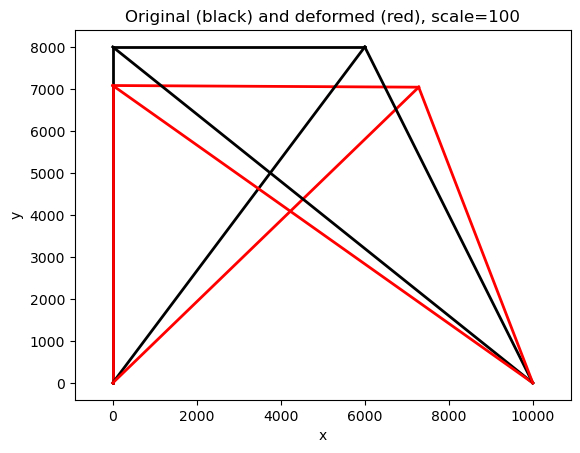

In [136]:
plot_truss_deformation(nodes, elements, u_global, scale=100)

### Calculating all member level outputs

We loop over members and compute:
- `u_e` (element global displacements)
- `u_local` (element local displacements)
- `f_local` (element local end forces)
- `N` (axial force) and `sigma` (axial stress)

In [137]:
def recover_element_results(elements, elements_csl, u_global):
    results = {}

    for e_id, (i, j, E_e, A_e) in elements.items():
        c, s, L = elements_csl[e_id]

        u_e = extract_element_displacements(u_global, i, j)
        u_local = compute_local_displacements(c, s, u_e)
        f_local = compute_local_end_forces(E_e, A_e, L, u_local)
        N, sigma = compute_axial_force_and_stress(E_e, A_e, L, u_local)

        results[e_id] = {
            "u_e": u_e,
            "u_local": u_local,
            "f_local": f_local,
            "N": N,          # kN
            "sigma": sigma,  # GPa
        }

    return results

results = recover_element_results(elements, elements_csl, u_global)


### Building a Results Table

Next, we assemble a Pandas table with **one row per element**.
For reporting, we convert stress from GPa → MPa.

In [138]:
import pandas as pd
rows = []
for e_id in sorted(elements.keys()):
    i, j, _, _ = elements[e_id]
    c, s, L = elements_csl[e_id]
    r = results[e_id]

    row = {
        "ele": e_id,
        "i": i,
        "j": j,
        "L (mm)": round(L, 1),
        "N (kN)": round(r["N"], 1),
        "sigma (MPa)": round(r["sigma"] * 1000, 1),
    }

    # global displacements u_e
    row.update({f"u_{k+1} (mm)": round(r["u_e"][k], 1) for k in range(4)})
    # local displacements u'
    row.update({f"u_{k+1}' (mm)": round(r["u_local"][k], 1) for k in range(4)})
    # local end forces f'
    row.update({f"f_{k+1}' (kN)": round(r["f_local"][k], 1) for k in range(4)})

    rows.append(row)

df_members = pd.DataFrame(rows)


In [139]:
def display_compact(df):
    return (
        df.style
        .format({
            col: "{:.1f}"
            for col in df.columns
            if any(key in col for key in ["(mm)", "(kN)", "(MPa)", "L"])
        })
        .set_properties(**{
            "font-size": "9pt",
            "padding": "2px",
            "white-space": "nowrap",
        })
        .set_table_styles([
            {"selector": "th", "props": [("font-size", "9pt")]},
        ])
    )
display_compact(df_members)

,ele,i,j,L (mm),N (kN),sigma (MPa),u_1 (mm),u_2 (mm),u_3 (mm),u_4 (mm),u_1' (mm),u_2' (mm),u_3' (mm),u_4' (mm),f_1' (kN),f_2' (kN),f_3' (kN),f_4' (kN)
0,1,1,3,8000.0,-321.6,-80.4,0.0,0.0,0.0,-9.2,0.0,0.0,-9.2,0.0,321.6,0.0,-321.6,0.0
1,2,3,4,6000.0,599.0,149.8,0.0,-9.2,12.8,-9.6,0.0,-9.2,12.8,-9.6,-599.0,0.0,599.0,0.0
2,3,1,4,10000.0,1.0,0.2,0.0,0.0,12.8,-9.6,0.0,0.0,0.0,-16.0,-1.0,0.0,1.0,0.0
3,4,2,3,12806.2,-125.5,-31.4,0.0,0.0,0.0,-9.2,0.0,0.0,-5.7,7.2,125.5,0.0,-125.5,0.0
4,5,2,4,8944.3,-448.1,-112.0,0.0,0.0,12.8,-9.6,0.0,0.0,-14.3,-7.2,448.1,0.0,-448.1,0.0


In [140]:
# Export DataFrame to Excel
df_members.to_csv("member_results.csv", index=False)

## Part 9 - In Class Truss Assignments

### Solve this Truss Using the Code in this Lecture

Example 3.4 in Kassimali (not fully worked out)

<div style="display:flex; gap:1.5rem; align-items:center;">
  <div style="flex:0.5;">
    <img src="assets/L2_ClassProblem1.png" style="width:100%; margin-bottom:0.75rem;">
  </div>
  <div style="flex:0.5; font-size:0.95em;">
    <p><strong>Node numbering (different than textbook):</strong></p>
    <ul>
      <li>Node 1: bottom-left</li>
      <li>Node 2: top left</li>
      <li>Node 3: top right</li>
      <li>Node 4: bottom right</li>
    </ul>
  </div>
</div>

### Solve this Truss Using the Code in this Lecture

Example 3.8 in Kassimali

<div style="display:flex; gap:1.5rem; align-items:center;">
  <div style="flex:0.5;">
    <img src="assets/L2_ClassProblem3.png" style="width:100%; margin-bottom:0.75rem;">
  </div>
  <div style="flex:0.5; font-size:0.95em;">
    <p><strong>Node numbering (different than textbook):</strong></p>
    <ul>
      <li>Node 1: bottom-left support</li>
      <li>Node 2: middle support</li>
      <li>Node 3: top node</li>
      <li>Node 4: right support</li>
    </ul>
  </div>
</div>